## Load the dependencies and configurations

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.configs import configs
configs

{'img_glob': '*.tif',
 'seg_glob': '*.npy',
 'default_output_directory_name': 'protein_localization_analysis',
 'tracking_features': ['centroid',
  'area',
  'major_axis_length',
  'minor_axis_length',
  'perimeter',
  'solidity',
  'moments_central'],
 'tracking_search_radius': 60,
 'node_dilations': 5,
 'edge_dilations': 4,
 'cyto_mask_erode_steps': 10,
 'cyto_mask_erode_footprint': <function skimage.morphology.footprints.square(width, dtype=<class 'numpy.uint8'>, *, decomposition=None)>,
 'dx_microns': None,
 'dy_microns': None,
 'dt_seconds': None,
 'n_processes': 1}

In [2]:
# these are needed to properly store and recover junction coordinates in Pandas dataframes
pd.set_option('display.max_colwidth', int(1e6))
np.set_printoptions(threshold=sys.maxsize)

## Load data (intensity images and segmentations)

In [4]:
from src.io import load_data

loader_inputs = {
    'channel_1_dirpath': './data/registered time points#8-1_R',
    'channel_2_dirpath': './data/registered time points#8-1_G',
    'seg_channel': 0,
    'img_glob':'*.tif',
    'seg_glob':'*.npy',
    'merge_channels': True,
}

data = load_data(**loader_inputs)

if loader_inputs['merge_channels']:
    print('img: {}, seg:{}'.format(data['img'].shape, data['seg'].shape))
else:
    print('img: {}, seg:{}'.format([arr.shape for arr in data['img'].values()], data['seg'].shape))

img: (2, 28, 467, 489), seg:(1, 28, 467, 489)


## Build cell outline networks (test)

In [5]:
from src.tissue_network import TissueNetwork

test_channel = 0
test_timepoint = 0
seg_channel = loader_inputs['seg_channel']

sample_img = data['img'][test_channel][test_timepoint]
sample_seg = data['seg'][seg_channel][test_timepoint]

tissue_network = TissueNetwork(sample_seg)
network = tissue_network.build()

network.keys()

100%|██████████| 210/210 [00:00<00:00, 27248.38it/s]


dict_keys(['skeleton', 'graph', 'edge_labels', 'node_labels'])

## Visualize cell outline networks

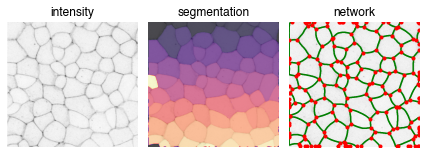

In [6]:
fig, ax = plt.subplots(ncols=3)

ax[0].imshow(sample_img, cmap='gray_r')
ax[1].imshow(sample_img, cmap='gray_r')
ax[1].imshow(sample_seg, cmap='magma', alpha=0.7, zorder=10)
ax[2].imshow(sample_img, cmap='gray_r')

_graph = network['graph']

# draw edges by pts
for (s,e) in _graph.edges():
    ps = _graph[s][e]['pts']
    ax[2].plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = _graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
ax[2].plot(ps[:,1], ps[:,0], 'r.')

ax[0].set_title('intensity')
ax[1].set_title('segmentation')
ax[2].set_title('network')

for axi in ax: axi.axis('off')
fig.tight_layout(pad=1)
fig.savefig('assets/sample_pipeline.png', dpi=300, bbox_inches='tight')

## Run cyto analyzer (all cells and all times)

In [7]:
from src.cells import tabulate_cells, CytoAnalyzer

cyto_analyzer = CytoAnalyzer(imgs=data['img'], seg_masks=data['seg'])

cells_tables = cyto_analyzer.run()

CytoAnalyzer started with imgs: (2, 28, 467, 489) and seg masks: (1, 28, 467, 489)


Generating cytoplasmic masks...: 100%|##########| 28/28 [00:36<00:00,  1.31s/it]


## Run junctions analyzer (bi- and multi-cellular junctions; all cells and all times)

In [10]:
from src.junctions import JunctionsAnalyzer

junctions_analyzer = JunctionsAnalyzer(imgs=data['img'], seg_masks=data['seg'])
junctions_analyzer.generate_networks()

generating networks...: 100%|##########| 28/28 [00:42<00:00,  1.52s/it]


In [11]:
edge_tables = junctions_analyzer.tabulate_edges()

generating junctions tables for frame 0...: 210it [00:07, 29.09it/s]0:00<?, ?it/s]
generating junctions tables for frame 1...: 216it [00:07, 30.55it/s]0:07<03:14,  7.22s/it]
generating junctions tables for frame 2...: 206it [00:06, 30.74it/s]0:14<03:05,  7.13s/it]
generating junctions tables for frame 3...: 209it [00:06, 30.20it/s]0:20<02:53,  6.94s/it]
generating junctions tables for frame 4...: 208it [00:06, 30.56it/s]0:27<02:46,  6.93s/it]
generating junctions tables for frame 5...: 216it [00:07, 30.28it/s]0:34<02:38,  6.89s/it]
generating junctions tables for frame 6...: 224it [00:07, 30.61it/s]0:41<02:33,  6.97s/it]
generating junctions tables for frame 7...: 232it [00:07, 30.06it/s]0:49<02:28,  7.09s/it]
generating junctions tables for frame 8...: 236it [00:07, 30.61it/s]0:56<02:25,  7.29s/it]
generating junctions tables for frame 9...: 244it [00:07, 30.78it/s]1:04<02:20,  7.42s/it]
generating junctions tables for frame 10...: 249it [00:08, 30.80it/s]1:12<02:16,  7.58s/it]
genera

In [12]:
node_tables = junctions_analyzer.tabulate_nodes()

generating junctions tables for frame 0...: 210it [00:07, 29.11it/s] [00:00<?, ?it/s]
generating junctions tables for frame 1...: 216it [00:07, 28.91it/s] [00:07<03:14,  7.22s/it]
generating junctions tables for frame 2...: 206it [00:07, 28.50it/s] [00:14<03:11,  7.37s/it]
generating junctions tables for frame 3...: 209it [00:07, 28.49it/s] [00:21<03:02,  7.30s/it]
generating junctions tables for frame 4...: 208it [00:07, 28.66it/s] [00:29<02:55,  7.32s/it]
generating junctions tables for frame 5...: 216it [00:07, 29.11it/s] [00:36<02:47,  7.30s/it]
generating junctions tables for frame 6...: 224it [00:07, 29.13it/s] [00:43<02:41,  7.34s/it]
generating junctions tables for frame 7...: 232it [00:07, 29.07it/s] [00:51<02:36,  7.46s/it]
generating junctions tables for frame 8...: 236it [00:08, 29.30it/s] [00:59<02:32,  7.62s/it]
generating junctions tables for frame 9...: 244it [00:08, 28.90it/s] [01:07<02:27,  7.76s/it]
generating junctions tables for frame 10...: 249it [00:08, 29.10it/s

## Visualize cell morphology measurements

Drawing cell areas...:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing cell orientations...: 100%|##########| 1/1 [00:00<00:00,  1.35it/s]


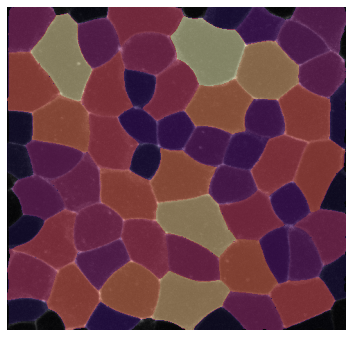

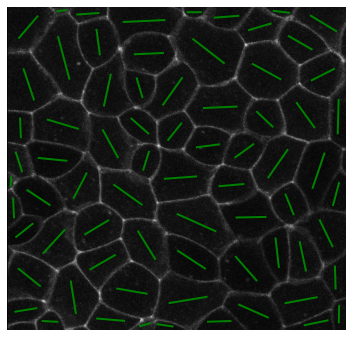

In [13]:
from src.visualization import TissuePlotter

# the visualizer requires the channel and time axes
_img = sample_img[np.newaxis, np.newaxis, ...]
_seg = sample_seg[np.newaxis, np.newaxis, ...]

plotter = TissuePlotter(_img, _seg)
plotter.plot(field='area', channel=0, savedir='./output', display=True )
plotter.plot(field='orientation', channel=0, savedir='./output', display=True )